In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset, random_split
import pandas as pd
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.metrics import f1_score,accuracy_score,classification_report
import numpy as np
import shutil
import os

In [2]:
TRAIN_FOLDER = "icon_data/train/"
# TEST_FOLDER  = "/kaggle/input/sadat-icons/icon_data/test/"

In [3]:
!mkdir images

A subdirectory or file images already exists.


In [4]:
class_2_id = {}
id_2_class = {}
i=0
for folder in os.listdir(TRAIN_FOLDER):
    class_2_id[folder]=i
    id_2_class[i]=folder
    i+=1

In [5]:
id_2_class

{0: 'back',
 1: 'Briefcase',
 2: 'Call',
 3: 'Camera',
 4: 'Circle',
 5: 'Cloud',
 6: 'delete',
 7: 'Down',
 8: 'edit',
 9: 'Export',
 10: 'Face',
 11: 'Folder',
 12: 'Globe',
 13: 'Google',
 14: 'Heart',
 15: 'Home',
 16: 'Image',
 17: 'Import',
 18: 'Info',
 19: 'Link',
 20: 'Location',
 21: 'Mail',
 22: 'menu',
 23: 'Merge',
 24: 'Message',
 25: 'Microphone',
 26: 'more',
 27: 'Music',
 28: 'Mute',
 29: 'Person',
 30: 'Phone',
 31: 'plus',
 32: 'QRCODE',
 33: 'Refresh',
 34: 'search',
 35: 'settings',
 36: 'share',
 37: 'Star',
 38: 'Tick',
 39: 'Up',
 40: 'vidCam',
 41: 'Video',
 42: 'Volume'}

In [6]:
id_2_class

{0: 'back',
 1: 'Briefcase',
 2: 'Call',
 3: 'Camera',
 4: 'Circle',
 5: 'Cloud',
 6: 'delete',
 7: 'Down',
 8: 'edit',
 9: 'Export',
 10: 'Face',
 11: 'Folder',
 12: 'Globe',
 13: 'Google',
 14: 'Heart',
 15: 'Home',
 16: 'Image',
 17: 'Import',
 18: 'Info',
 19: 'Link',
 20: 'Location',
 21: 'Mail',
 22: 'menu',
 23: 'Merge',
 24: 'Message',
 25: 'Microphone',
 26: 'more',
 27: 'Music',
 28: 'Mute',
 29: 'Person',
 30: 'Phone',
 31: 'plus',
 32: 'QRCODE',
 33: 'Refresh',
 34: 'search',
 35: 'settings',
 36: 'share',
 37: 'Star',
 38: 'Tick',
 39: 'Up',
 40: 'vidCam',
 41: 'Video',
 42: 'Volume'}

In [25]:
#save to json

import json
with open('id_2_class.json', 'w') as fp:
    json.dump(id_2_class, fp)

In [7]:
for_csv = {
    "id":[],
    "label":[],
    "text_label":[]
}
IMG_SIZE = 224
i = 0

FOLDER = TRAIN_FOLDER
for folder in os.listdir(FOLDER):
    folder_path = os.path.join(FOLDER, folder)
    for image in os.listdir(folder_path):
        image_path = os.path.join(folder_path,image)
        try:
            img = Image.open(image_path).resize((IMG_SIZE,IMG_SIZE)).convert("L")
            img.save("images/"+str(i)+".jpg")
            for_csv["id"].append(i)
            for_csv["label"].append(class_2_id[folder])
            for_csv["text_label"].append(folder)
            i+=1
        except:
            continue

# FOLDER = TEST_FOLDER
# for folder in os.listdir(FOLDER):
#     folder_path = os.path.join(FOLDER, folder)
#     for image in os.listdir(folder_path):
#         image_path = os.path.join(folder_path,image)
#         try:
#             img = Image.open(image_path).resize((IMG_SIZE,IMG_SIZE)).convert("RGB")
#             img.save("images/"+str(i)+".jpg")
#             for_csv["id"].append(i)
#             for_csv["label"].append(class_2_id[folder])
#             for_csv["text_label"].append(folder)
#             i+=1
#         except:
#             continue

c:\Users\User\miniconda3\envs\textgen\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [8]:

# Load the CSV file
labels_df = pd.DataFrame(for_csv, index=None)

In [9]:
labels_df = labels_df.sample(frac=1).reset_index(drop=True)

In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_dataframe_by_label(df, frac):

    # Ensure that frac is between 0 and 1
    if not (0 <= frac <= 1):
        raise ValueError("The fraction must be between 0 and 1.")

    # Initialize empty dataframes for the split
    df_first = pd.DataFrame(columns=df.columns)
    df_second = pd.DataFrame(columns=df.columns)

    # Iterate over each label and split the data
    for label in df['label'].unique():
        label_df = df[df['label'] == label]
        df1, df2 = train_test_split(label_df, train_size=frac, random_state=42)
        df_first = pd.concat([df_first, df1])
        df_second = pd.concat([df_second, df2])

    return df_first, df_second

# Example usage
# df_first, df_second = split_dataframe_by_label(your_dataframe, 0.7)


In [11]:
train_df, test_df = split_dataframe_by_label(labels_df, 0.8)

In [12]:
def undersample_dataframe(df, max_samples):
    # Check if max_samples is a positive integer
    if not isinstance(max_samples, int) or max_samples <= 0:
        raise ValueError("max_samples must be a positive integer.")

    # Group by label and undersample each group
    grouped = df.groupby('label')
    undersampled_df = pd.DataFrame(grouped.apply(lambda x: x.sample(min(len(x), max_samples))))

    # Reset index after groupby and sampling
    undersampled_df.reset_index(drop=True, inplace=True)

    return undersampled_df


In [13]:
def upsample_dataframe(df, min_samples):

    # Check if min_samples is a positive integer
    if not isinstance(min_samples, int) or min_samples <= 0:
        raise ValueError("min_samples must be a positive integer.")

    # Group by label and upsample each group
    grouped = df.groupby('label')
    upsampled_df = pd.DataFrame(grouped.apply(lambda x: x.sample(min_samples, replace=True) if len(x) < min_samples else x))

    # Reset index after groupby and sampling
    upsampled_df.reset_index(drop=True, inplace=True)

    return upsampled_df



In [14]:
train_df = upsample_dataframe(train_df,100)
# test_df  = undersample_dataframe(test_df,100)
# train_df = undersample_dataframe(train_df,150)

In [15]:
count_dict = {}
for i, row in train_df.iterrows():
    l = row["label"]
    if l in count_dict:
        count_dict[l]+=1
    else:
        count_dict[l]=1

count_dict2 = {}

for i, row in test_df.iterrows():
    l = row["label"]
    if l in count_dict2:
        count_dict2[l]+=1
    else:
        count_dict2[l]=1

for i in range(len(class_2_id)):
    print(i, count_dict[i], count_dict2[i])

0 127 32
1 174 44
2 236 60
3 100 22
4 120 31
5 198 50
6 130 33
7 122 31
8 103 26
9 182 46
10 100 22
11 198 50
12 141 36
13 198 50
14 198 50
15 198 50
16 160 41
17 157 40
18 100 22
19 173 44
20 113 29
21 152 39
22 109 28
23 197 50
24 100 17
25 180 45
26 101 26
27 116 29
28 199 50
29 151 38
30 100 25
31 100 24
32 198 50
33 199 50
34 100 25
35 100 23
36 100 17
37 197 50
38 205 52
39 204 51
40 100 14
41 104 27
42 192 48


In [16]:
FOLDER = "images/"

In [17]:
# Define the transformation
test_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])

train_transform = transforms.Compose([
#     transforms.Resize((224, 224)),
    transforms.RandomApply([transforms.ColorJitter(0.3, 0.3, 0.0, 0.0)], p=0.5), #brightness, contrast, saturation, hue
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])
])


# Define a custom dataset
class IconDataset(Dataset):
    def __init__(self, labels_frame, root_dir, transform=None):
        self.labels_frame = labels_frame
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_frame)

    def __getitem__(self, idx):
        img_name = f"{self.root_dir}/{self.labels_frame.iloc[idx, 0]}.jpg"
        image = Image.open(img_name).convert("RGB")
        label = self.labels_frame.iloc[idx, 1]

        if self.transform:
            image = self.transform(image)

        return image, label


# Create dataset
train_dataset = IconDataset(labels_frame=train_df, root_dir=FOLDER, transform=train_transform)
test_dataset = IconDataset(labels_frame=test_df, root_dir=FOLDER, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# CNN Model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.fc1 = nn.Linear(32 * 224 * 224, 37)  # Assuming images are 224x224

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.softmax(self.fc1(x),dim=0)
        return x

class MaxViT(nn.Module):
    def __init__(self):
        super(MaxViT, self).__init__()
        model = models.maxvit_t(weights="DEFAULT")
        num_ftrs = model.classifier[5].in_features
        model.classifier[5] = nn.Linear(num_ftrs, len(class_2_id))
        self.model = model
    def forward(self, x):
        return self.model(x)

# Instantiate the model
model = MaxViT().to("cuda")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1 - epoch / 100)


c:\Users\User\miniconda3\envs\textgen\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3484.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [18]:
best_f1 = 0
# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs.to("cuda"))
        loss = criterion(outputs, labels.to("cuda"))
        loss.backward()
        optimizer.step()
    scheduler.step()

    # Validation loop
    model.eval()
    total = 0
    all_labels = []
    all_predicted = []
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            outputs = model(inputs.to("cuda"))
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            all_labels.append(labels.numpy())
            all_predicted.append(predicted.detach().to("cpu").numpy())
            
    all_labels = np.concatenate(all_labels)
    all_predicted = np.concatenate(all_predicted)
    f1 = f1_score(all_labels,all_predicted, average='macro')
    acc = accuracy_score(all_labels,all_predicted)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {acc*100}% F1: {f1}")

    if f1>best_f1:
        best_f1 = f1
        torch.save(model.state_dict(), 'best_model.pth')
        print('Model weights saved.')
        print(classification_report(all_labels,all_predicted))

100%|██████████| 50/50 [00:07<00:00,  6.99it/s]


Epoch 1/20, Loss: 0.6631521582603455, Accuracy: 80.97038437303088% F1: 0.8143231843539931
Model weights saved.
              precision    recall  f1-score   support

           0       0.93      0.88      0.90        32
           1       0.95      0.93      0.94        44
           2       0.98      0.90      0.94        60
           3       0.81      1.00      0.90        22
           4       0.73      0.71      0.72        31
           5       0.64      0.92      0.75        50
           6       0.89      1.00      0.94        33
           7       0.78      0.81      0.79        31
           8       0.93      1.00      0.96        26
           9       0.76      0.76      0.76        46
          10       0.88      0.68      0.77        22
          11       0.78      0.86      0.82        50
          12       0.85      0.94      0.89        36
          13       1.00      0.50      0.67        50
          14       1.00      0.50      0.67        50
          15       0.75 

100%|██████████| 50/50 [00:04<00:00, 11.72it/s]


Epoch 2/20, Loss: 0.5732803344726562, Accuracy: 84.7511027095148% F1: 0.8471072856598753
Model weights saved.
              precision    recall  f1-score   support

           0       0.79      0.97      0.87        32
           1       1.00      0.86      0.93        44
           2       0.97      0.97      0.97        60
           3       0.91      0.91      0.91        22
           4       0.82      0.74      0.78        31
           5       0.84      0.86      0.85        50
           6       0.92      1.00      0.96        33
           7       0.54      0.90      0.67        31
           8       0.84      1.00      0.91        26
           9       0.71      0.80      0.76        46
          10       0.82      0.64      0.72        22
          11       0.90      0.94      0.92        50
          12       0.78      0.97      0.86        36
          13       0.83      0.70      0.76        50
          14       0.88      0.72      0.79        50
          15       0.83  

100%|██████████| 50/50 [00:04<00:00, 11.99it/s]


Epoch 3/20, Loss: 0.7223578095436096, Accuracy: 85.82230623818525% F1: 0.8563987625960884
Model weights saved.
              precision    recall  f1-score   support

           0       0.84      0.97      0.90        32
           1       1.00      0.91      0.95        44
           2       0.97      0.97      0.97        60
           3       0.95      0.91      0.93        22
           4       0.79      0.74      0.77        31
           5       0.65      0.94      0.77        50
           6       0.97      1.00      0.99        33
           7       0.86      0.77      0.81        31
           8       1.00      0.92      0.96        26
           9       0.81      0.76      0.79        46
          10       0.67      0.82      0.73        22
          11       0.88      0.92      0.90        50
          12       0.92      0.97      0.95        36
          13       0.90      0.86      0.88        50
          14       0.92      0.68      0.78        50
          15       0.88 

100%|██████████| 50/50 [00:04<00:00, 11.83it/s]


Epoch 4/20, Loss: 0.5389899015426636, Accuracy: 83.30182734719597% F1: 0.8397030664461608


100%|██████████| 50/50 [00:04<00:00, 11.84it/s]


Epoch 5/20, Loss: 0.26058411598205566, Accuracy: 86.7044738500315% F1: 0.8652079255655145
Model weights saved.
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        32
           1       0.93      0.95      0.94        44
           2       0.98      0.95      0.97        60
           3       0.95      0.91      0.93        22
           4       0.69      0.77      0.73        31
           5       0.83      0.90      0.87        50
           6       1.00      0.94      0.97        33
           7       0.69      0.94      0.79        31
           8       0.96      0.96      0.96        26
           9       0.65      0.85      0.74        46
          10       0.94      0.77      0.85        22
          11       0.98      0.84      0.90        50
          12       0.94      0.92      0.93        36
          13       0.91      0.84      0.87        50
          14       0.92      0.66      0.77        50
          15       0.91 

100%|██████████| 50/50 [00:04<00:00, 11.78it/s]


Epoch 6/20, Loss: 0.11516380310058594, Accuracy: 86.32640201638311% F1: 0.8651042180451826


100%|██████████| 50/50 [00:04<00:00, 11.75it/s]


Epoch 7/20, Loss: 0.2884931266307831, Accuracy: 84.05797101449275% F1: 0.8479193552665635


100%|██████████| 50/50 [00:04<00:00, 11.63it/s]


Epoch 8/20, Loss: 0.4003789722919464, Accuracy: 85.1291745431632% F1: 0.8538440496150018


100%|██████████| 50/50 [00:04<00:00, 11.92it/s]


Epoch 9/20, Loss: 0.17860029637813568, Accuracy: 87.77567737870196% F1: 0.8782015659184909
Model weights saved.
              precision    recall  f1-score   support

           0       0.90      0.88      0.89        32
           1       1.00      0.93      0.96        44
           2       0.95      0.97      0.96        60
           3       0.84      0.95      0.89        22
           4       0.79      0.74      0.77        31
           5       0.77      0.92      0.84        50
           6       0.97      1.00      0.99        33
           7       0.83      0.81      0.82        31
           8       1.00      0.96      0.98        26
           9       0.85      0.87      0.86        46
          10       0.95      0.82      0.88        22
          11       0.94      0.88      0.91        50
          12       0.90      1.00      0.95        36
          13       1.00      0.66      0.80        50
          14       0.80      0.82      0.81        50
          15       0.75

100%|██████████| 50/50 [00:04<00:00, 11.80it/s]


Epoch 10/20, Loss: 0.2623906135559082, Accuracy: 85.94833018273472% F1: 0.8568683109835779


100%|██████████| 50/50 [00:04<00:00, 11.82it/s]


Epoch 11/20, Loss: 0.03642905130982399, Accuracy: 87.46061751732829% F1: 0.8752476652110971


100%|██████████| 50/50 [00:04<00:00, 11.74it/s]


Epoch 12/20, Loss: 0.04971063882112503, Accuracy: 88.84688090737241% F1: 0.8874316680196108
Model weights saved.
              precision    recall  f1-score   support

           0       0.91      0.97      0.94        32
           1       0.98      1.00      0.99        44
           2       0.98      0.95      0.97        60
           3       1.00      0.95      0.98        22
           4       0.70      0.84      0.76        31
           5       0.80      0.94      0.86        50
           6       1.00      1.00      1.00        33
           7       0.85      0.90      0.88        31
           8       0.96      1.00      0.98        26
           9       0.72      0.89      0.80        46
          10       1.00      0.64      0.78        22
          11       0.87      0.90      0.88        50
          12       0.97      1.00      0.99        36
          13       1.00      0.84      0.91        50
          14       0.95      0.74      0.83        50
          15       0.9

100%|██████████| 50/50 [00:04<00:00, 11.69it/s]


Epoch 13/20, Loss: 0.24502374231815338, Accuracy: 88.78386893509767% F1: 0.8914100815186707
Model weights saved.
              precision    recall  f1-score   support

           0       0.86      0.97      0.91        32
           1       0.98      0.93      0.95        44
           2       0.97      0.95      0.96        60
           3       0.95      0.86      0.90        22
           4       0.64      0.81      0.71        31
           5       0.85      0.92      0.88        50
           6       0.92      1.00      0.96        33
           7       0.83      0.94      0.88        31
           8       1.00      0.88      0.94        26
           9       0.67      0.87      0.75        46
          10       1.00      0.77      0.87        22
          11       0.91      0.82      0.86        50
          12       0.95      0.97      0.96        36
          13       0.95      0.80      0.87        50
          14       0.93      0.80      0.86        50
          15       0.8

100%|██████████| 50/50 [00:04<00:00, 11.94it/s]


Epoch 14/20, Loss: 0.12690715491771698, Accuracy: 87.0825456836799% F1: 0.8691777714430017


100%|██████████| 50/50 [00:04<00:00, 11.89it/s]


Epoch 15/20, Loss: 0.039787568151950836, Accuracy: 87.52362948960302% F1: 0.8785891393604705


100%|██████████| 50/50 [00:04<00:00, 11.79it/s]


Epoch 16/20, Loss: 0.09257231652736664, Accuracy: 87.96471329552615% F1: 0.8818484762362288


100%|██████████| 50/50 [00:04<00:00, 11.83it/s]


Epoch 17/20, Loss: 0.14385418593883514, Accuracy: 87.0825456836799% F1: 0.870063776256168


100%|██████████| 50/50 [00:04<00:00, 11.77it/s]


Epoch 18/20, Loss: 0.1985616385936737, Accuracy: 87.58664146187776% F1: 0.8737545801811116


100%|██████████| 50/50 [00:04<00:00, 11.60it/s]


Epoch 19/20, Loss: 0.007958111353218555, Accuracy: 88.21676118462508% F1: 0.8797355118295431


100%|██████████| 50/50 [00:04<00:00, 11.94it/s]

Epoch 20/20, Loss: 0.3914642035961151, Accuracy: 86.7044738500315% F1: 0.8674478996558217


In [20]:
#load best model
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

In [21]:
list_ = []
PATH = "icon_data/UNKNOWN/"
for image_name in os.listdir(PATH):
    image = Image.open(PATH+image_name).resize((224,224)).convert("RGB")
    image_tensor = test_transform(image).to("cuda")

    with torch.no_grad():
        res = F.softmax(model(image_tensor.unsqueeze(0)))
    
    list_.append(torch.max(res[0]).to("cpu").tolist())
    
#     print(tensor_entropy(res[0]))
#     print([id_2_class[i] for i in torch.topk(res,5,dim=1).indices[0].to("cpu").tolist()])

C:\Users\User\AppData\Local\Temp\ipykernel_33268\1528050369.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  res = F.softmax(model(image_tensor.unsqueeze(0)))
c:\Users\User\miniconda3\envs\textgen\lib\site-packages\PIL\Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


<BarContainer object of 321 artists>

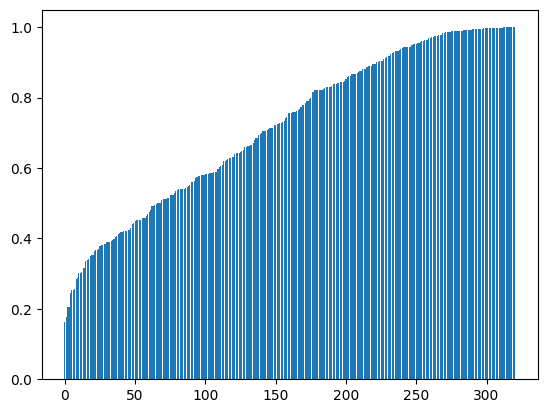

In [22]:
from matplotlib import pyplot as plt
list_.sort()

plt.bar( range(len(list_)) ,list_)

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_33268\864543475.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  outputs = F.softmax(model(inputs.to("cuda")))
100%|██████████| 50/50 [00:04<00:00, 10.82it/s]


<BarContainer object of 1587 artists>

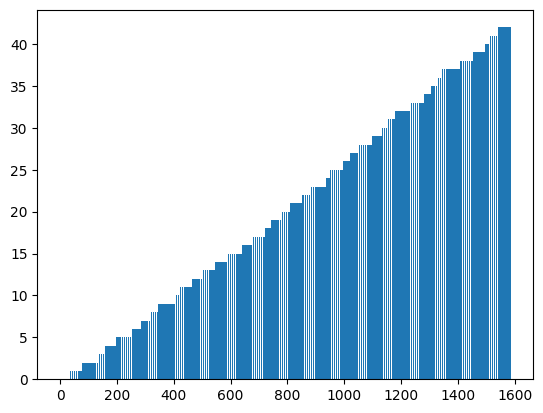

In [23]:
model.eval()
total = 0
all_labels = []
all_predicted = []

all_vals = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader):
        outputs = F.softmax(model(inputs.to("cuda")))
        val, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        all_predicted+=predicted.detach().to("cpu").tolist()
        all_vals+=val.detach().to("cpu").tolist()
        all_labels+=labels
        
all_predicted.sort()

plt.bar( range(len(test_dataset)) ,all_vals)